## Research Question

The research question that we hope to answer is if we can determine customer sentiment from the wording of reviews. By doing this we hope to be able to guage if a customer likes or dislikes a product.

Using natural language processing, our goal is to analyize the wording within customer reviews to predict if a customer has a positive or negative feeling about a product.

Our analysis will be conducted using TensorFlow neural networks

## Data Prep

In [1]:
# Package importing
import json
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks

Using TensorFlow backend.


In [2]:
# Parse for json gzip file
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

In [3]:
# Turn our json file into data frame
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [4]:
# Importing data
df = getDF('Luxury_Beauty_5.json.gz')
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN


Looking at our data frame, we want to select the overall score and the review text columns.

In [5]:
# New data frame with out selected columns
df = df[['overall','reviewText']]
df.head()

,overall,reviewText
0,5.0,This handcream has a beautiful fragrance. It d...
1,5.0,"wonderful hand lotion, for seriously dry skin,..."
2,5.0,"Best hand cream around. Silky, thick, soaks i..."
3,5.0,Thanks!!
4,5.0,Great hand lotion. Soaks right in and leaves ...


In [6]:
# Changing column names
df = df.rename(columns={'overall': 'Score', 'reviewText': 'Review'})
df.head()

,Score,Review
0,5.0,This handcream has a beautiful fragrance. It d...
1,5.0,"wonderful hand lotion, for seriously dry skin,..."
2,5.0,"Best hand cream around. Silky, thick, soaks i..."
3,5.0,Thanks!!
4,5.0,Great hand lotion. Soaks right in and leaves ...


In [7]:
# Check for any nulls
df.isna().any()

Score     False
Review     True
dtype: bool

In [8]:
# Remove our nulls
df = df.dropna(subset=['Review'])

In [9]:
# Check for any nulls again
df.isna().any()

Score     False
Review    False
dtype: bool

We can see our dataframe no longer contains any nulls

In [10]:
# Creating sentiments column to gauge review 0-2 negative, 3-5 positive
# 0 = negative, 1 = positive
df['Sentiments'] = df.Score.apply(lambda x: 0 if x in [1, 2] else 1)
df.head()

,Score,Review,Sentiments
0,5.0,This handcream has a beautiful fragrance. It d...,1
1,5.0,"wonderful hand lotion, for seriously dry skin,...",1
2,5.0,"Best hand cream around. Silky, thick, soaks i...",1
3,5.0,Thanks!!,1
4,5.0,Great hand lotion. Soaks right in and leaves ...,1


In [11]:
# Selecting our special characters
unique_char = ["!",'"',"#","%","&","'","(",")",
 "*","+",",","-",".","/",":",";","<",
 "=",">","?","@","[","\\","]","^","_",
 "`","{","|","}","~","–"]

In [12]:
# replacing our special characters
for char in unique_char:
 df['Review'] = df['Review'].str.replace(char, ' ',regex=True)

# Replacing all capitals with lowercase
df['Review'] = df['Review'].str.lower()

df.head()

,Score,Review,Sentiments
0,5.0,this handcream has a beautiful fragrance it d...,1
1,5.0,wonderful hand lotion for seriously dry skin ...,1
2,5.0,best hand cream around silky thick soaks i...,1
3,5.0,thanks,1
4,5.0,great hand lotion soaks right in and leaves ...,1


In [13]:
# exporting our prepped data
df.to_csv('cleaned_task2.csv', index = False)

To continue our analysis, we must tokenize the stings of words. This will convert words in the sentence string into their own string. By doing this we will be able to run analysis on each word, instead of the main string. 

In [14]:
# Splitting data into 80/20 training and testing
split = round(len(df)*0.8)
train_reviews = df['Review'][:split]
train_label = df['Sentiments'][:split]
test_reviews = df['Review'][split:]
test_label = df['Sentiments'][split:]

In [15]:
# Setting up the split after tokenization
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
for row in train_reviews:
    training_sentences.append(str(row))
for row in train_label:
    training_labels.append(row)
for row in test_reviews:
    testing_sentences.append(str(row))
for row in test_label:
    testing_labels.append(row)

In [16]:
# Training at 50000 words
vocab_size = 50000
# 16 dimensions
embedding_dim = 16
# Max length of 120 words per review
max_length = 120
# Truncating after 120 
trunc_type = 'post'
oov_tok = '<OOV>'
# Padding after 120
padding_type = 'post'

In [17]:
# Starting the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# Fitting the tokenizer
tokenizer.fit_on_texts(training_sentences)
# Getting our word index
word_index = tokenizer.word_index

In [18]:
# Setting sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
# Setting padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

## Network Architecture

In [19]:
# Creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

Using TensorFlow, we can create our Keras model. Our embedding layer was previously set up with our chosen parameters. Our GlobalAveragePooling1D is set to output a 2D object and our third layer is set to relu activation with 10. The next two layers are set to 6 and 1 with relu activation respectively. By using relu, we are running linear activation, I am running this as we are working with binary 1 and 0 for our outputs. This will provide high accuracy with fewer tests needed to run.  

In [20]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Using binary_crossentropy for our analysis allows us to better analyze our binary output from our Keras model. Combining this loss function with the adam optimizer allows us to run a very efficient analysis with little requirement for extra memory. 

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           800000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                170       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 800,243
Trainable params: 800,243
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Training the model
training_final = np.array(training_labels)
testing_final = np.array(testing_labels)

## Model Evaluation

In [23]:
# Running the model for 25 epochs
model1 = model.fit(padded, training_final, epochs=25, validation_data=(testing_padded,
testing_final))

Train on 27412 samples, validate on 6853 samples
Epoch 1/25
27412/27412 [==============================] - 12s 449us/sample - loss: 0.7161 - accuracy: 0.7107 - val_loss: 0.2384 - val_accuracy: 0.9259
Epoch 2/25
27412/27412 [==============================] - 11s 392us/sample - loss: 0.1985 - accuracy: 0.9243 - val_loss: 0.2491 - val_accuracy: 0.9260
Epoch 3/25
27412/27412 [==============================] - 12s 450us/sample - loss: 0.1650 - accuracy: 0.9270 - val_loss: 0.2658 - val_accuracy: 0.9273
Epoch 4/25
27412/27412 [==============================] - 11s 419us/sample - loss: 0.1399 - accuracy: 0.9370 - val_loss: 0.3563 - val_accuracy: 0.9302
Epoch 5/25
27412/27412 [==============================] - 12s 428us/sample - loss: 0.1225 - accuracy: 0.9466 - val_loss: 0.3539 - val_accuracy: 0.9262
Epoch 6/25
27412/27412 [==============================] - 12s 427us/sample - loss: 0.0986 - accuracy: 0.9599 - val_loss: 0.4092 - val_accuracy: 0.9257
Epoch 7/25
27412/27412 [=====================

In [24]:
# Early stopping to prevent overfitting of our model
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

# Running model again
model2 = model.fit(padded, training_final, epochs=25, validation_data=(testing_padded,
                                                                       testing_final),
                                                                       callbacks = [earlystopping])

Train on 27412 samples, validate on 6853 samples
Epoch 1/25
27412/27412 [==============================] - 11s 399us/sample - loss: 0.0374 - accuracy: 0.9949 - val_loss: 1.0323 - val_accuracy: 0.9095
Epoch 2/25
27412/27412 [==============================] - 11s 405us/sample - loss: 0.0364 - accuracy: 0.9950 - val_loss: 1.0899 - val_accuracy: 0.9079
Epoch 3/25
27412/27412 [==============================] - 11s 394us/sample - loss: 0.1101 - accuracy: 0.9899 - val_loss: 1.0562 - val_accuracy: 0.9108
Epoch 4/25
27412/27412 [==============================] - 11s 391us/sample - loss: 0.0336 - accuracy: 0.9961 - val_loss: 1.1165 - val_accuracy: 0.9087
Epoch 5/25
27412/27412 [==============================] - 11s 395us/sample - loss: 0.0353 - accuracy: 0.9959 - val_loss: 1.1333 - val_accuracy: 0.9063
Epoch 6/25
27412/27412 [==============================] - 11s 402us/sample - loss: 0.0357 - accuracy: 0.9961 - val_loss: 1.1785 - val_accuracy: 0.9028


We can see our model now stops at 6, preventing overfitting.

We can see that our accuracy stops at .9961 and our val_accuracy is .9028. Using this we can argue that our model has a prediction model that is 90% correct in predicting customer sentiment based on words in a review. 

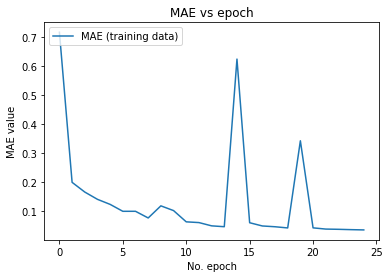

In [26]:
# epoch vs Mean Absolute Error
plt.plot(model1.history['loss'], label='MAE (training data)')
plt.title('MAE vs epoch')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

After 6 epochs we begin to drop, showing that 6 is our optimal number of tests to run

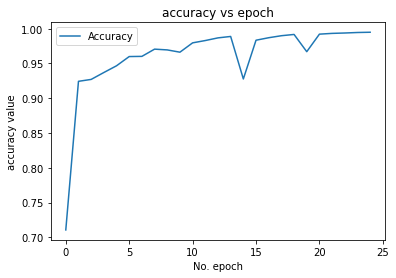

In [27]:
plt.plot(model1.history['accuracy'], label='Accuracy')
plt.title('accuracy vs epoch')
plt.ylabel('accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

<Figure size 432x288 with 0 Axes>

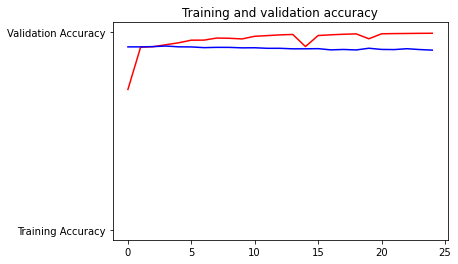

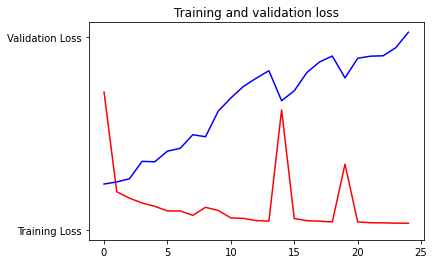

<Figure size 432x288 with 0 Axes>

In [28]:
acc = model1.history['accuracy']
val_acc = model1.history['val_accuracy']
loss = model1.history['loss']
val_loss = model1.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

## Summary and Recommendations

Our final prediction model had an output with 90% accuracy in predicting customer sentiment. This is a good outcome and we can use that to argue that our model works and will predict customer sentiment with 90% accuracy. Fine-tuning the network allows us to zero in on the parameters that will present the most accurate and fine-tuned model. Setting up our stop point allows us to prevent overfitting, even with an increase in accuracy. The tradeoff of this is that we get the best model that we can, without needed to overfit the model. 


For our stakeholders, the accuracy of our model is a key indication that they can trust our model. Using our analysis they can better predict customer sentiment based on the predictive outcomes of our model. Based on word usage in a review, our company can predict what a customer may rate a product and take a course of action based on the prediction. Rolling our prediction model into an overall customer retention strategy can help to prevent churn or better engineer products that customers may rate positively.